## Differentiation anchors tutorial

### A. Preprocessing: Find your trajectories

#### I. Create your eGRN annData object

In [1]:
import matplotlib
matplotlib.__version__

'3.5.2'

In [ ]:
# Imports
import scanpy as sc
import numpy as np
# Plotting 
import matplotlib
import matplotlib.pyplot as plt
# Inline plotting
%matplotlib inline
# Reset random seed
np.random.seed(5)

In [ ]:
# Load data
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/'
import dill
infile = open(outDir+'scplus_obj.pkl', 'rb')
scplus_obj = dill.load(infile)
infile.close()

In [ ]:
# Create anndata from AUC matrix (use both gene and region-based cistromes)
import pandas as pd
import anndata
import sklearn
auc_key = 'eRegulon_AUC'
signature_keys = ['Gene_based', 'Region_based']
scale = False
if scale == True:
    data_mat = pd.concat([pd.DataFrame(sklearn.preprocessing.StandardScaler().fit_transform(
            scplus_obj.uns[auc_key][x].T), index=scplus_obj.uns[auc_key][x].T.index.to_list(), columns=scplus_obj.uns[auc_key][x].T.columns) for x in signature_keys])
else:
    data_mat = pd.concat([scplus_obj.uns[auc_key][x].T for x in signature_keys])
selected_regulons = [x for x in data_mat.index if '+_+' in x or '-_+' in x]
data_mat = data_mat.loc[selected_regulons]
adata = anndata.AnnData(X=data_mat.T.copy())
adata.obs = scplus_obj.metadata_cell.copy()

In [ ]:
adata

In [4]:
set(adata.obs['GEX_consensus_cell_type'])
set(adata.obs['GEX_sample_id'])

{'10x_complex', '10x_complex_UC', '10x_no_perm', 'TST', 'TST_NP40_004'}

In [5]:
# Keep only cell types involved in the differentiation trajectory
adata = adata[adata.obs['GEX_consensus_cell_type'].isin(['OPC', 'OL'])]
adata = adata[adata.obs['GEX_sample_id'].isin(['TST_NP40_004', 'TST', '10x_complex_UC'])]

In [6]:
# Select variable eGRNs
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=200)

/opt/venv/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


#### II. Find your trajectory with PAGA

In [7]:
# Reanalyze this subset of cells
# Make PCA
sc.tl.pca(adata)
import scanpy.external as sce
sce.pp.harmony_integrate(adata, 'GEX_sample_id')
# Make diffusion map
print('DiffMap')
sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.diffmap(adata, random_state=5)
# Make umap
print('Umap')
sc.tl.umap(adata)
# Make tsne
print('TSNE')
sc.tl.tsne(adata, use_rep='X_pca_harmony')
# Make graph
print('Graph')
sc.tl.draw_graph(adata)

2022-05-06 11:58:16,205 - harmonypy - INFO - Iteration 1 of 10
2022-05-06 11:58:20,616 - harmonypy - INFO - Iteration 2 of 10
2022-05-06 11:58:24,805 - harmonypy - INFO - Iteration 3 of 10
2022-05-06 11:58:30,584 - harmonypy - INFO - Iteration 4 of 10
2022-05-06 11:58:37,581 - harmonypy - INFO - Iteration 5 of 10
2022-05-06 11:58:41,450 - harmonypy - INFO - Iteration 6 of 10
2022-05-06 11:58:46,777 - harmonypy - INFO - Converged after 6 iterations


DiffMap
Umap
TSNE
Graph


In [10]:
sc.tl.tsne(adata, use_rep='X_pca_harmony')

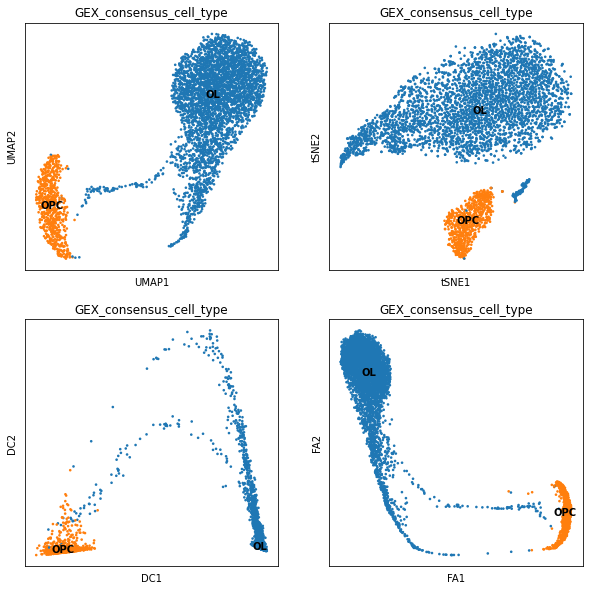

In [11]:
# Visualize
import matplotlib.pyplot as plt
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1_dict = sc.pl.umap(adata, color='GEX_consensus_cell_type', legend_loc='on data', ax=ax1, show=False)
#ax2_dict = sc.pl.umap(adata, color='GEX_sample_id', legend_loc='on data', ax=ax2, show=False)
ax2_dict = sc.pl.tsne(adata, color='GEX_consensus_cell_type', legend_loc='on data', ax=ax2, show=False)
ax3_dict = sc.pl.diffmap(adata, color='GEX_consensus_cell_type', legend_loc='on data', ax=ax3, show=False)
ax4_dict = sc.pl.draw_graph(adata, color='GEX_consensus_cell_type', legend_loc='on data', ax=ax4, show=False)

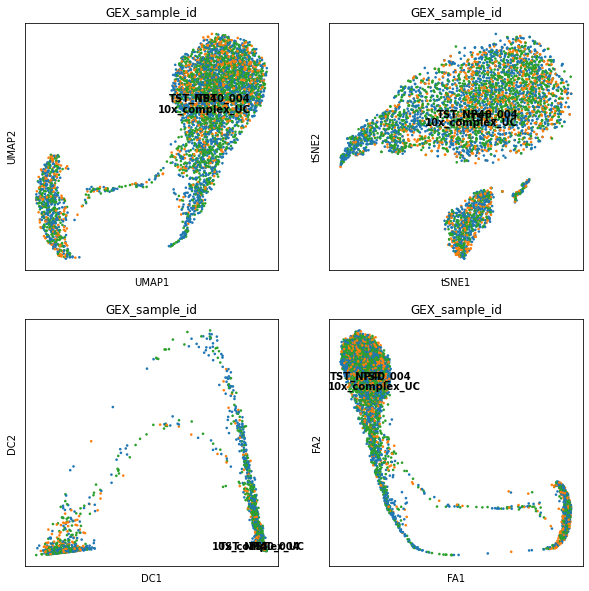

In [12]:
# Visualize
import matplotlib.pyplot as plt
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1_dict = sc.pl.umap(adata, color='GEX_sample_id', legend_loc='on data', ax=ax1, show=False)
#ax2_dict = sc.pl.umap(adata, color='GEX_sample_id', legend_loc='on data', ax=ax2, show=False)
ax2_dict = sc.pl.tsne(adata, color='GEX_sample_id', legend_loc='on data', ax=ax2, show=False)
ax3_dict = sc.pl.diffmap(adata, color='GEX_sample_id', legend_loc='on data', ax=ax3, show=False)
ax4_dict = sc.pl.draw_graph(adata, color='GEX_sample_id', legend_loc='on data', ax=ax4, show=False)

In [ ]:
# Run PAGA
sc.tl.paga(adata, groups='GEX_consensus_cell_type')
%matplotlib inline
sc.pl.paga(adata, color='GEX_sample_id')

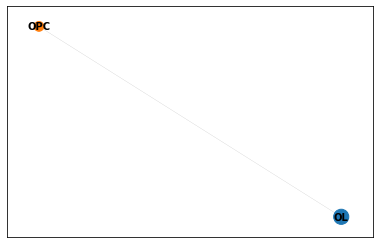

In [23]:
sc.tl.paga(adata, groups='GEX_consensus_cell_type')
adata.uns['paga']['connectivities'] = adata.uns['paga']['connectivities'].todense()
sc.pl.paga(adata, color='GEX_consensus_cell_type', threshold=0)

In [24]:
# Redo UMAP using PAGA map
sc.tl.umap(adata, init_pos='paga')

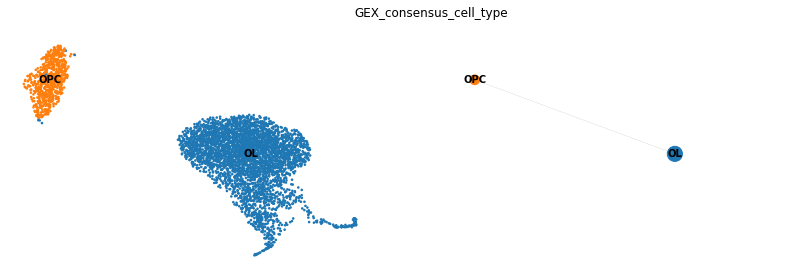

In [26]:
# Visualize. We see that paths split in PR_Early, but this is not true, it is due to the broas definition of cell types (it should be MF or SMW)
sc.tl.paga(adata, groups='GEX_consensus_cell_type')
sc.pl.paga_compare(adata, basis='umap', threshold=0)

In [28]:
adata.obs = adata.obs.iloc[:,0:20] # To avoid weird error about a column
adata.write_h5ad('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/differenrentiation_tutorial_1.h5ad')

#### IV. Add gene expression to anndata

In [1]:
# To read
import scanpy as sc
adata = sc.read_h5ad('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/differenrentiation_tutorial_1.h5ad')

In [2]:
adata

AnnData object with n_obs × n_vars = 4435 × 736
    obs: 'GEX_orig.ident', 'GEX_Leiden_res1', 'GEX_consensus_cell_type', 'GEX_conserved_cell_type', 'GEX_location', 'GEX_sample_id', 'GEX_barcode', 'ACC_cisTopic_nr_acc', 'ACC_cisTopic_nr_frag', 'ACC_FRIP', 'ACC_Unique_nr_frag_in_regions', 'ACC_Log_total_nr_frag', 'ACC_Dupl_rate', 'ACC_Dupl_nr_frag', 'ACC_cisTopic_log_nr_acc', 'ACC_Total_nr_frag', 'ACC_Total_nr_frag_in_regions', 'ACC_Unique_nr_frag', 'ACC_Log_unique_nr_frag', 'ACC_TSS_enrichment'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'GEX_consensus_cell_type_colors', 'GEX_consensus_cell_type_sizes', 'GEX_sample_id_colors', 'diffmap_evals', 'draw_graph', 'hvg', 'neighbors', 'paga', 'pca', 'tsne', 'umap'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_pca_harmony', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [21]:
# Needed for TF expression
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/'
import dill
infile = open(outDir+'scplus_obj.pkl', 'rb')
scplus_obj = dill.load(infile)
infile.close()

In [41]:
import pandas as pd
import anndata
import sklearn
adata_gene = anndata.AnnData(X=scplus_obj.to_df('EXP').copy())
sc.pp.normalize_total(adata_gene, target_sum=1e4)
sc.pp.log1p(adata_gene)
import scanpy as sc, anndata as ad, numpy as np, pandas as pd
adata_all = ad.concat([adata, adata_gene], axis=1, merge='unique', uns_merge='unique').copy()

In [42]:
# Save
adata_all.write_h5ad('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/differenrentiation_tutorial_2.h5ad')

#### III. Refine annotation on Second Mitotic Wave

In [37]:
# To read
import scanpy as sc
adata = sc.read_h5ad('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/differenrentiation_tutorial_2.h5ad')

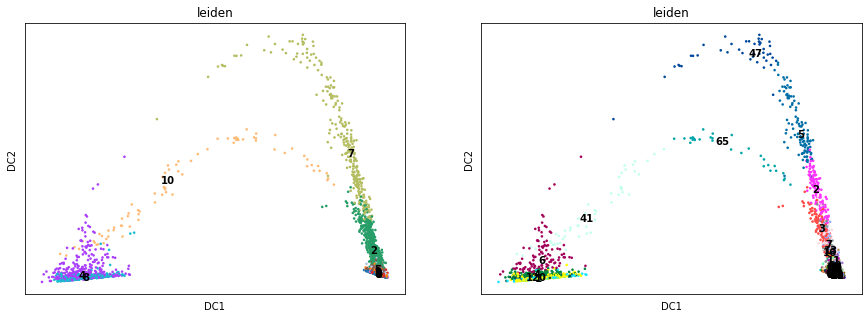

In [38]:
# Rename the division point as SMW.
import matplotlib.pyplot as plt
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,5))
sc.tl.leiden(adata, resolution=1)
ax1_dict = sc.pl.diffmap(adata, color='leiden', legend_loc='on data', ax=ax1, show=False)
sc.tl.leiden(adata, resolution=5)
ax2_dict = sc.pl.diffmap(adata, color='leiden', legend_loc='on data', ax=ax2, show=False)

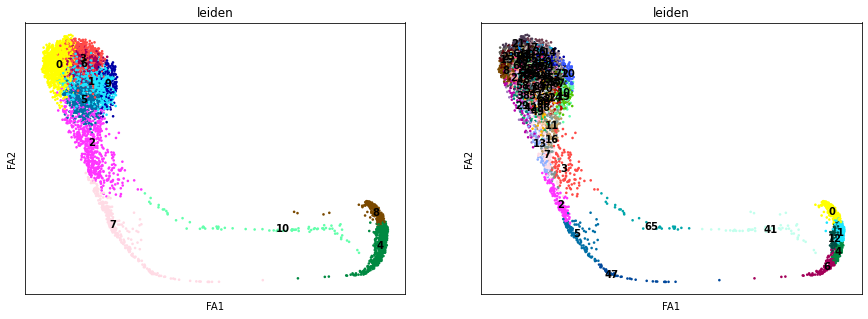

In [39]:
# Rename the division point as SMW.
import matplotlib.pyplot as plt
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,5))
sc.tl.leiden(adata, resolution=1)
ax1_dict = sc.pl.draw_graph(adata, color='leiden', legend_loc='on data', ax=ax1, show=False)
sc.tl.leiden(adata, resolution=5)
ax2_dict = sc.pl.draw_graph(adata, color='leiden', legend_loc='on data', ax=ax2, show=False)

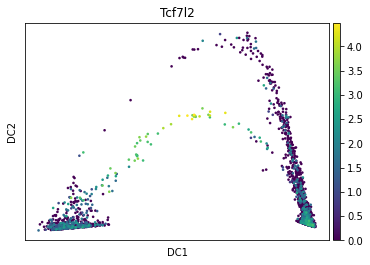

In [40]:
sc.pl.diffmap(adata, color='Tcf7l2', legend_loc='on data', show=True)

In [41]:
# Broad annotation
sc.tl.leiden(adata, resolution=1)
adata.obs['Diff_state'] = adata.obs['GEX_consensus_cell_type'].astype(str)
adata.obs.loc[adata.obs['leiden'] == '10','Diff_state'] = 'NFOL'

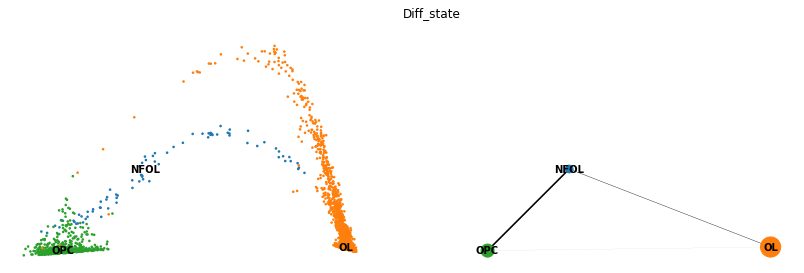

In [42]:
# PAGA graph with broad annotation. Looks good!
sc.tl.paga(adata, groups='Diff_state')
sc.pl.paga_compare(adata, basis='diffmap', threshold=0)

In [43]:
# Add RNA umap coordinates
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
import itertools
import anndata
path_to_loom = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/data/MO_GEX_seurat_Cortex.loom'
loom = SCopeLoom.read_loom(path_to_loom)

In [44]:
cell_data = get_metadata(loom)
# Fix names
cell_data = cell_data.replace('TEW__c14e1d__Multiome_RNA_brain_10x_no_perm', '10x_no_perm')
cell_data = cell_data.replace('TEW__3cc0d9__bb22bc__Multiome_brain_TST_NP40_004', 'TST_NP40_004')
cell_data = cell_data.replace('TEW__75da5c__5b0f59__Multiome_brain_TST', 'TST')
cell_data = cell_data.replace('TEW__c3f7c1__1ac906__Multiome_brain_10xcomplex_UC', '10x_complex_UC')
cell_data = cell_data.replace('TEW__d112c8__547ada__Multiome_RNA_brain_10x_complex', '10x_complex')
cell_data['barcode'] = [x.split('___')[0] for x in cell_data.index.tolist()]
cell_data.index = cell_data['barcode'] + '___' + cell_data['sample_id']

In [45]:
embeddings = {key: loom.embeddings[key].get_embedding() for key in loom.embeddings.keys()}

In [46]:
embeddings['Seurat Harmony UMAP'].index = cell_data.index

In [48]:
adata.obsm['X_umap'] = embeddings['Seurat Harmony UMAP'].loc[adata.obs.index]

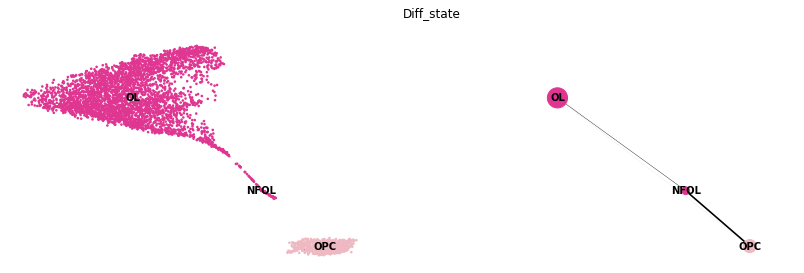

In [5]:
# PAGA graph with broad annotation. Looks good!
import os
os.chdir('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/')
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sc.tl.paga(adata, groups='Diff_state')
sc.pl.paga_compare(adata, basis='umap', threshold=0, palette={
        "OPC": "#eeb9c2",
        "NFOL": "#df3692",
        "OL": "#df3692",
    }, save='paga_plot.pdf')

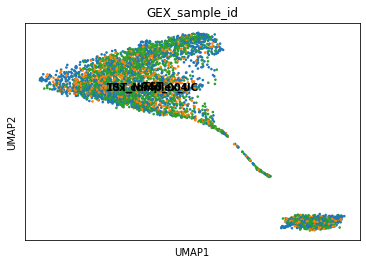

In [50]:
sc.pl.umap(adata, color='GEX_sample_id', legend_loc='on data', show=True)

In [51]:
adata.write_h5ad('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/differenrentiation_tutorial_3.h5ad')

#### V. Add embedding-based pseudotime

In [1]:
# To read
import scanpy as sc
adata = sc.read_h5ad('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/differenrentiation_tutorial_3.h5ad')

In [8]:
import pandas as pd
embedding = pd.DataFrame(adata.obsm['X_umap'], index=adata.obs.index, columns=['x', 'y'])
embedding.iloc[:,0] = embedding.iloc[:,0]+abs(min(embedding.iloc[:,0]))
embedding.iloc[:,1] = embedding.iloc[:,1]+abs(min(embedding.iloc[:,1]))
adata.obsm['X_umap'].columns = ['x', 'y']

/opt/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


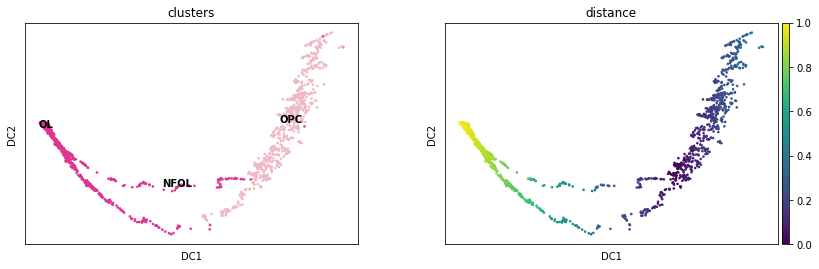

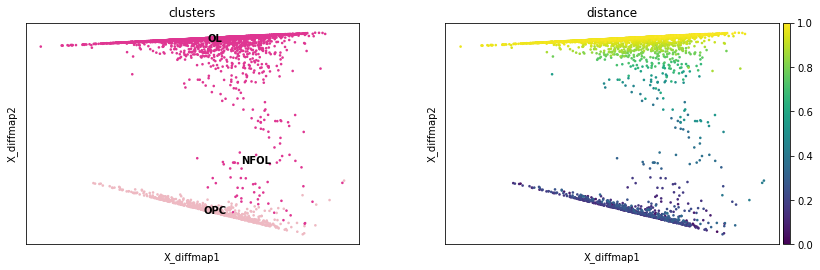

In [11]:
# Choose the embedding you want to plot arrows in. Here I will use the refined annotation because it separates better the branches in the diffusion map.
# The function will already save the annotations as clusters and distance, which are require for downstream steps.
#from scenicplus.differentiation_potential import *
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
import itertools
import anndata
import os
os.chdir('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/')
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
def get_embedding_dpt(adata, group_var, root_group, embedding_key='X_umap', n_dcs=2, figsize=(12,8), save=None):
    adata_h = anndata.AnnData(X=pd.DataFrame(adata.obsm[embedding_key], index=adata.obs.index))
    adata_h.obs = adata.obs.copy()
    sc.pp.neighbors(adata_h)
    adata_h.obs['clusters'] = adata_h.obs[group_var] 
    sc.tl.diffmap(adata_h, random_state=555)
    adata_h.uns['iroot'] = np.flatnonzero(adata_h.obs[group_var]  == root_group)[0]
    sc.tl.dpt(adata_h, n_dcs=n_dcs)
    adata_h.obs['distance'] = adata_h.obs['dpt_pseudotime']
    sc.pl.diffmap(adata_h, color=['clusters', 'distance'], legend_loc='on data', projection='2d', palette={
        "OPC": "#eeb9c2",
        "NFOL": "#df3692",
        "OL": "#df3692",
    }, save=save)
    adata.obs['dpt_pseudotime'] = adata_h.obs['dpt_pseudotime'].copy()
    adata.obs['distance'] = adata.obs['dpt_pseudotime']
    adata.obs['clusters'] = adata.obs[group_var] 
    sc.pl.embedding(adata, embedding_key, color=['clusters', 'distance'], legend_loc='on data', cmap='viridis', palette={
        "OPC": "#eeb9c2",
        "NFOL": "#df3692",
        "OL": "#df3692",
    })
get_embedding_dpt(adata, 'Diff_state', 'OPC', embedding_key='X_diffmap', n_dcs=2, figsize=(12,8), save='diffmap.pdf')

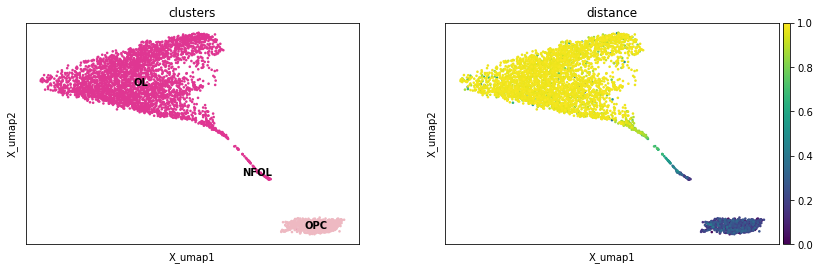

In [12]:
sc.pl.embedding(adata, 'X_umap', color=['clusters', 'distance'], legend_loc='on data', cmap='viridis', save='umao_dpt.pdf')

In [55]:
# Save
adata.write_h5ad('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/differenrentiation_tutorial_4.h5ad')

### B. Inferring differentiation arrows

In [13]:
# To read
import scanpy as sc
adata = sc.read_h5ad('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/differenrentiation_tutorial_4.h5ad')

In [14]:
# Set paths
paths = [('OL', ['OPC', 'NFOL', 'OL'])]

In [15]:
# Calculate path matrices
## Select path features
import os
selected_features = {}
selected_features['TF'] = list(set([x.split('_')[0] for x in adata.var.index.tolist() if 'g)' in x]))
selected_features['Region'] = [x for x in adata.var.index.tolist() if 'r)' in x]
selected_features['Gene'] = [x for x in adata.var.index.tolist() if 'g)' in x]
## Calculate
os.chdir('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/scenicplus/src/scenicplus')
from differentiation_potential import *
paths_cascade = {'TF':{}, 'Region':{}, 'Gene':{}}
for x in paths_cascade.keys():
    for ipath, (descr, path) in enumerate(paths):
        mat= get_path_matrix(
                adata, dpt_var = 'distance',
                path_var = 'clusters',
                path = path, features = selected_features[x],
                split_groups = True)
        paths_cascade[x][descr] = mat

In [17]:
# fix embeddings
embedding = pd.DataFrame(adata.obsm['X_umap'], index=adata.obs.index, columns=['x', 'y'])
embedding.iloc[:,0] = embedding.iloc[:,0]+abs(min(embedding.iloc[:,0]))
embedding.iloc[:,1] = embedding.iloc[:,1]+abs(min(embedding.iloc[:,1]))
adata.obsm['X_umap'].columns = ['x', 'y']

In [26]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
def plot_map(adata, paths_cascade, tf, color_var, embedding_key = 'X_umap', window=1,
             plot_type='tf_to_gene', gam_smooth = True, use_ranked_dpt = False, tf_traj_thr=0.7, tf_expr_thr=0.2, penalization = 0.03, n_grid_cols = 50,
             n_grid_rows = 50, n_neighbors = 10, offset_frac = 0.1, scale=100, n_cpu = 1,
             figsize =(10, 10), colormap = cm.Greys, plot_streamplot=True, vmax_streamplot=0.25, linewidth_streamplot=0.5, arrowsize_streamplot=2, density_streamplot=10, return_data = False, save=None, **kwargs):
    tf_name = tf.split('_')[0]
    ke = list(paths_cascade[list(paths_cascade.keys())[0]].keys())
    u_list = []
    v_list = []
    x_list = []
    y_list = []
    tf_expr_list = []
    for k in ke:
        df = plot_potential(adata, paths_cascade, k, tf, window=window, return_data=True, show_plot=False, gam_smooth=gam_smooth, use_ranked_dpt = use_ranked_dpt) 
        arrow_map = calculate_arrows(df, penalization)
        embedding = pd.DataFrame(adata.obsm[embedding_key], index=adata.obs.index, columns=['x', 'y'])
        embedding.iloc[:,0] = embedding.iloc[:,0]+abs(min(embedding.iloc[:,0]))
        embedding.iloc[:,1] = embedding.iloc[:,1]+abs(min(embedding.iloc[:,1]))
        embedding = embedding.loc[df.index]
        df = pd.concat([arrow_map, embedding], axis=1)
        df[plot_type+'_match'] =  [df[plot_type+'_match'][i] if not isnan(df[plot_type+'_match'][i]) else df.index[i] for i in range(df.shape[0]) ]
        df[plot_type+'_match'] =  [df[plot_type+'_match'][i] if df.iloc[i,0] > tf_traj_thr else df.index[i] for i in range(df.shape[0]) ]
        df[plot_type+'_match'] =  [df[plot_type+'_match'][i] if df.iloc[i,3] > tf_expr_thr else df.index[i] for i in range(df.shape[0]) ]
        df = df.loc[:,['x', 'y', plot_type+'_match', tf_name+'_all_paths']].dropna()
        x = df.loc[:,'x']
        y = df.loc[:,'y']
        u = np.array(df.loc[df[plot_type+'_match'], 'x'])-np.array(x)
        v = np.array(df.loc[df[plot_type+'_match'], 'y'])-np.array(y)
        tf_expr = np.array(df.iloc[:,3])
        u_list.append(u)
        v_list.append(v)
        x_list.append(x)
        y_list.append(y)
        tf_expr_list.append(tf_expr)
    u = np.concatenate(u_list)
    v = np.concatenate(v_list)
    x = np.concatenate(x_list)
    y = np.concatenate(y_list)
    tf_expr = np.concatenate(tf_expr_list)
    # Plot as grid
    embedding = np.array([x,y]).T
    delta_embedding = np.array([u,v]).T
    grid_xy, uv, mask, color = calculate_grid_arrows(embedding, delta_embedding, tf_expr, offset_frac, n_grid_cols, n_grid_rows, n_neighbors, n_cpu)
    from matplotlib.pyplot import rc_context
    with rc_context({'figure.figsize': figsize}):
        sc.pl.embedding(adata, embedding_key, color=[color_var], zorder=0, return_fig=True, title=tf, **kwargs) 
    if plot_streamplot is True:
        distances = np.sqrt((uv**2).sum(1))
        norm = matplotlib.colors.Normalize(vmin=0, vmax=vmax_streamplot, clip=True)
        mapper = cm.ScalarMappable(norm=norm, cmap=colormap)
        scale = lambda X: [(x - min(X)) / (max(X) - min(X)) for x in X]
        uv[~mask] = np.nan
        plt.streamplot(
                grid_xy.reshape(n_grid_cols,n_grid_cols, 2)[:, :, 0],
                grid_xy.reshape(n_grid_cols,n_grid_cols, 2)[:, :, 1],
                uv.reshape(n_grid_cols,n_grid_cols, 2)[:, :, 0],
                uv.reshape(n_grid_cols,n_grid_cols, 2)[:, :, 1], density = density_streamplot, color = np.array(scale(distances)).reshape(n_grid_cols,n_grid_cols), cmap = colormap, zorder = 1, norm = norm,
                linewidth = linewidth_streamplot, arrowsize=arrowsize_streamplot)
    else:    
        plt.quiver(grid_xy[mask, 0], grid_xy[mask, 1], uv[mask, 0], uv[mask, 1], zorder=1, color=colormap(color[mask]), scale=scale)
    if save is not None:
        plt.savefig(save)
    if return_data == True:
        return df

### 1. Olig2

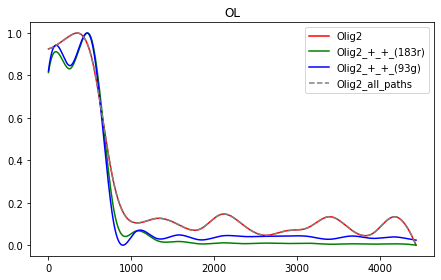

In [30]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'OL', 'Olig2_+_+', window=1, gam_smooth=True, return_data = True, use_ranked_dpt=True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/curve_plots/Olig2.pdf')

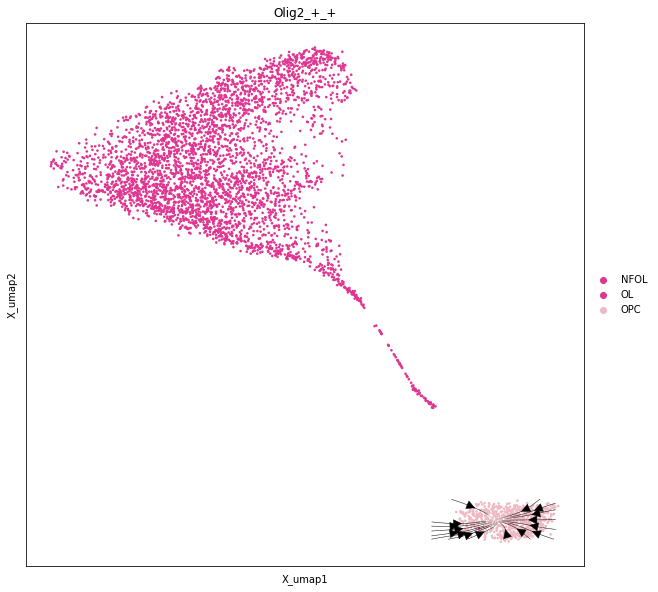

In [27]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Olig2_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0.7, tf_expr_thr=0.7, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Olig2.pdf')

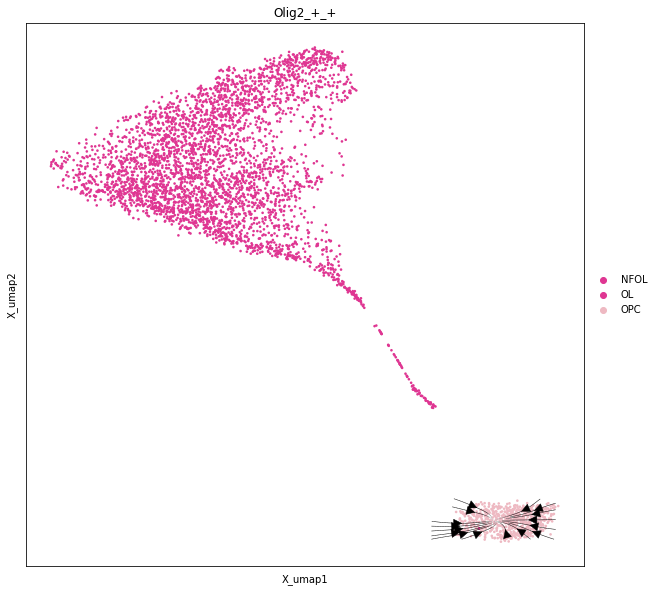

In [55]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Olig2_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0, tf_expr_thr=0, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Olig2_nothr.pdf')

### 2. Bcl6

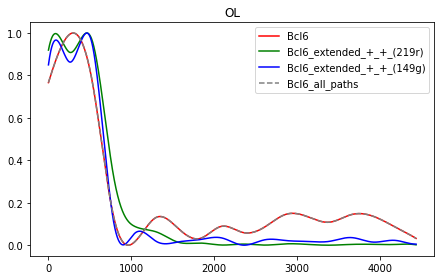

In [31]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'OL', 'Bcl6_extended_+_+', window=1, gam_smooth=True, return_data = True, use_ranked_dpt=True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/curve_plots/Bcl6.pdf')

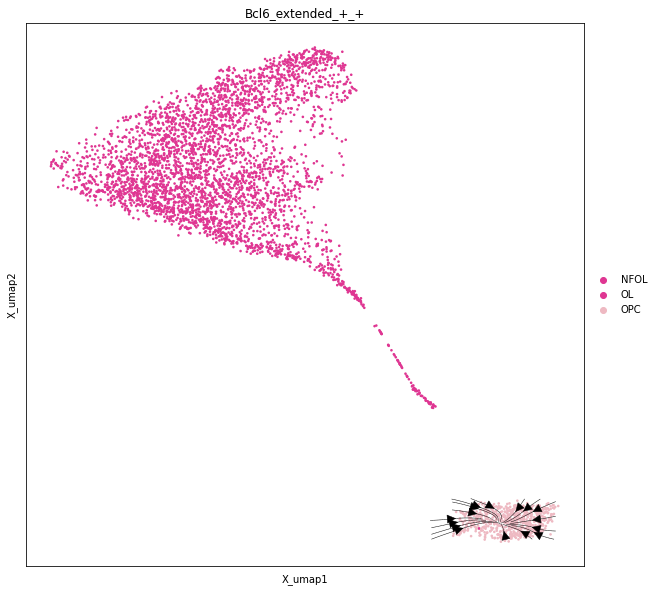

In [32]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Bcl6_extended_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0.7, tf_expr_thr=0.7, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Bcl6.pdf')

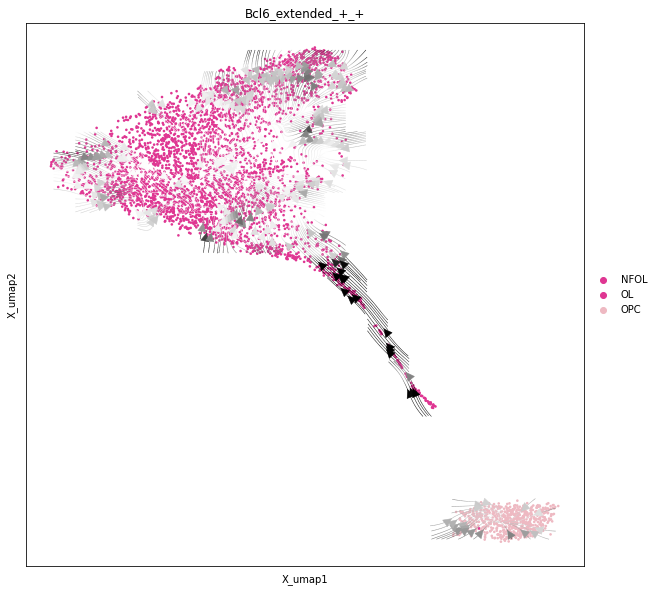

In [56]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Bcl6_extended_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0, tf_expr_thr=0, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Bcl6_nothr.pdf')

### 3. Prrx1

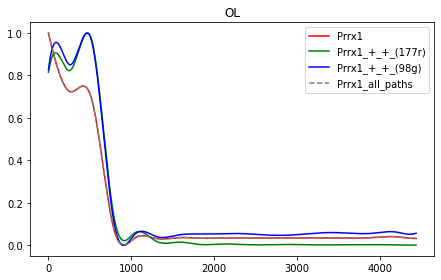

In [33]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'OL', 'Prrx1_+_+', window=1, gam_smooth=True, return_data = True, use_ranked_dpt=True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/curve_plots/Prrx1.pdf')

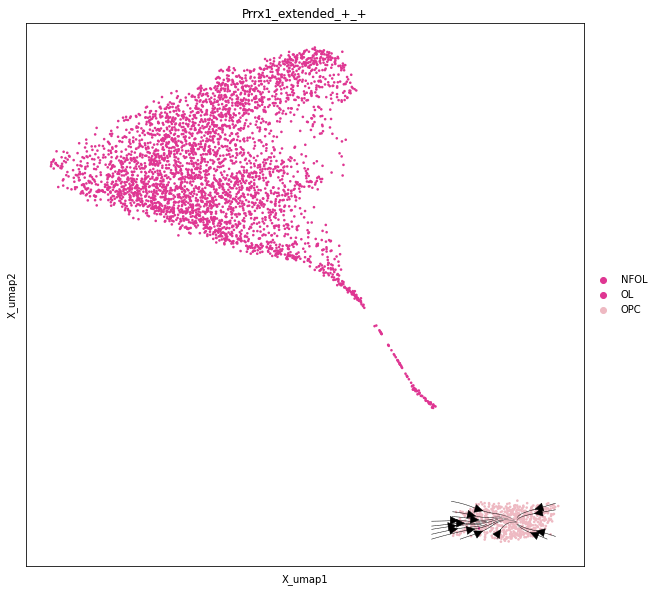

In [34]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Prrx1_extended_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0.7, tf_expr_thr=0.7, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Prrx1.pdf')

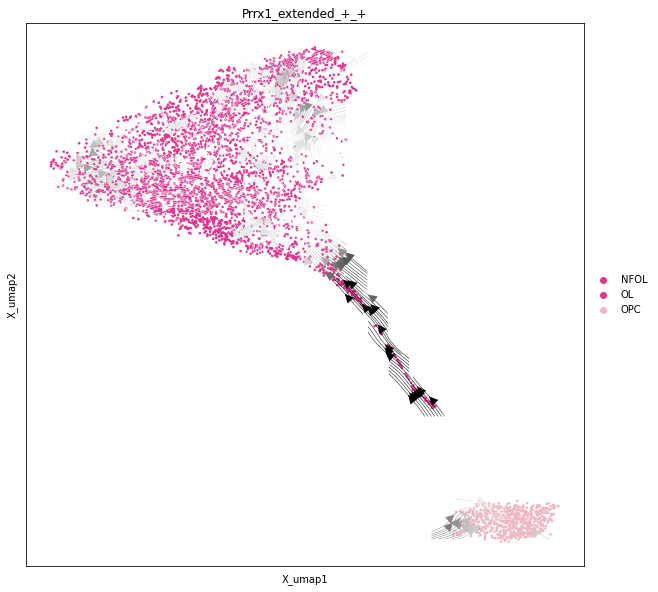

In [57]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Prrx1_extended_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0, tf_expr_thr=0, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Prrx1_nothr.pdf')

### 4. Sox4

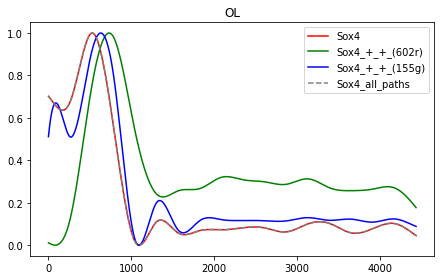

In [35]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'OL', 'Sox4_+_+', window=1, gam_smooth=True, return_data = True, use_ranked_dpt=True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/curve_plots/Sox4.pdf')

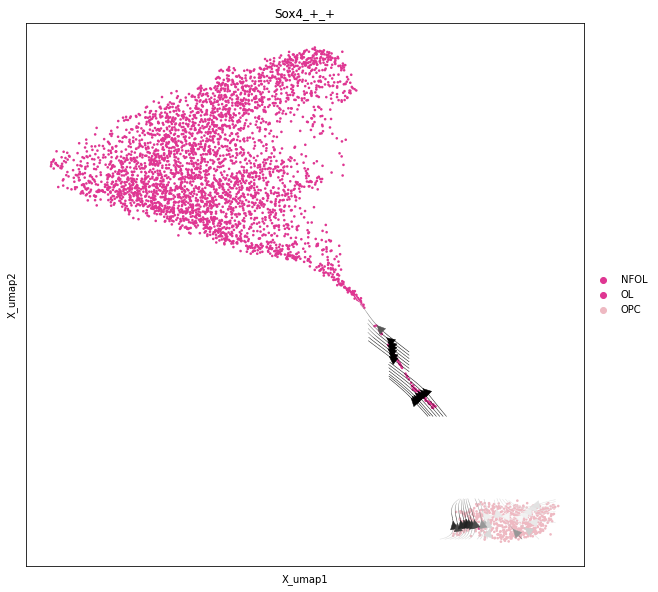

In [36]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Sox4_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0.7, tf_expr_thr=0.7, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Sox4.pdf')

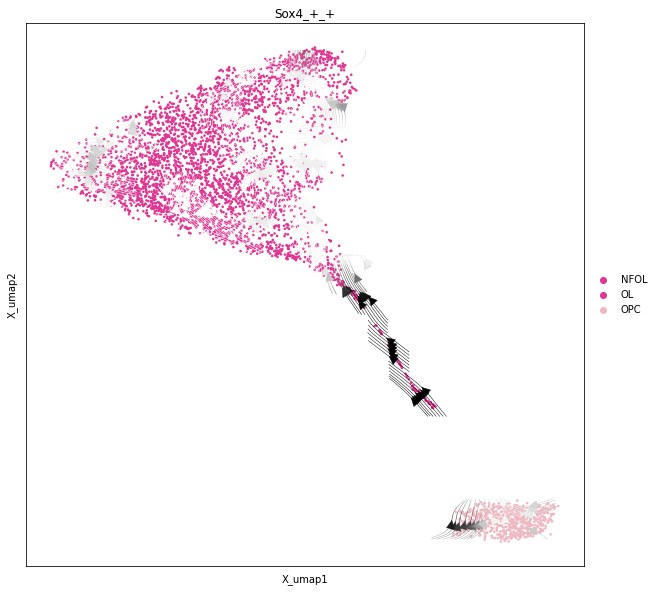

In [60]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Sox4_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0, tf_expr_thr=0.2, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Sox4_nothr.pdf')

### 5. Sox6

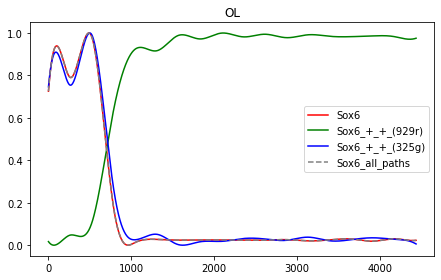

In [37]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'OL', 'Sox6_+_+', window=1, gam_smooth=True, return_data = True, use_ranked_dpt=True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/curve_plots/Sox6.pdf')

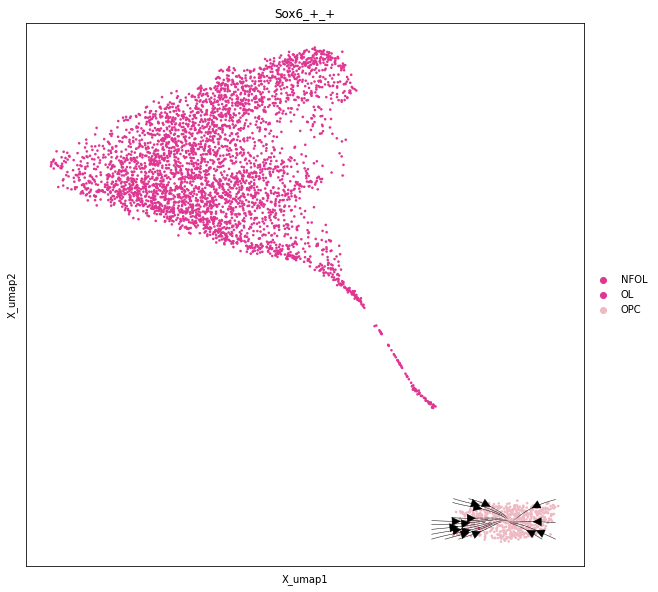

In [38]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Sox6_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0.7, tf_expr_thr=0.7, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Sox6.pdf')

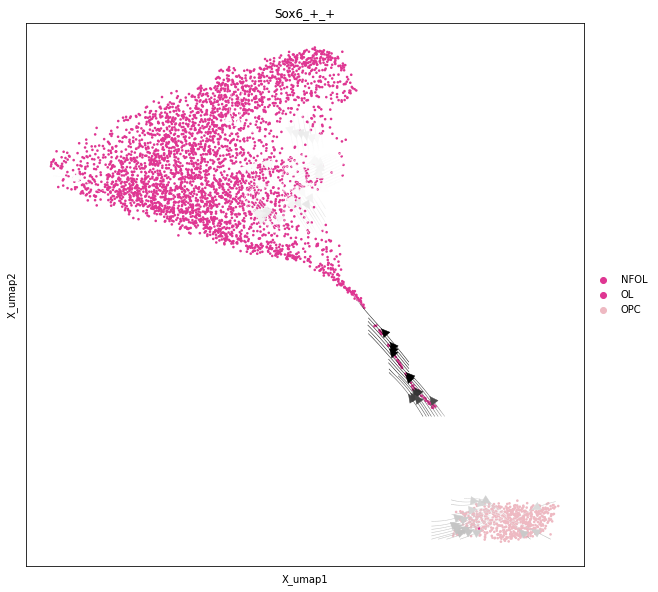

In [61]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Sox6_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0, tf_expr_thr=0.2, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Sox6_nothr.pdf')

### 6. Sox8

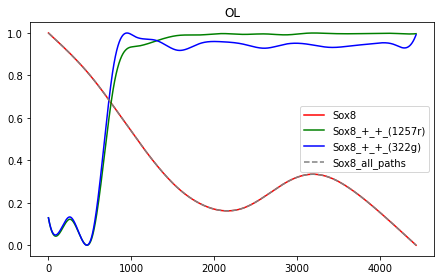

In [39]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'OL', 'Sox8_+_+', window=1, gam_smooth=True, return_data = True, use_ranked_dpt=True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/curve_plots/Sox8.pdf')

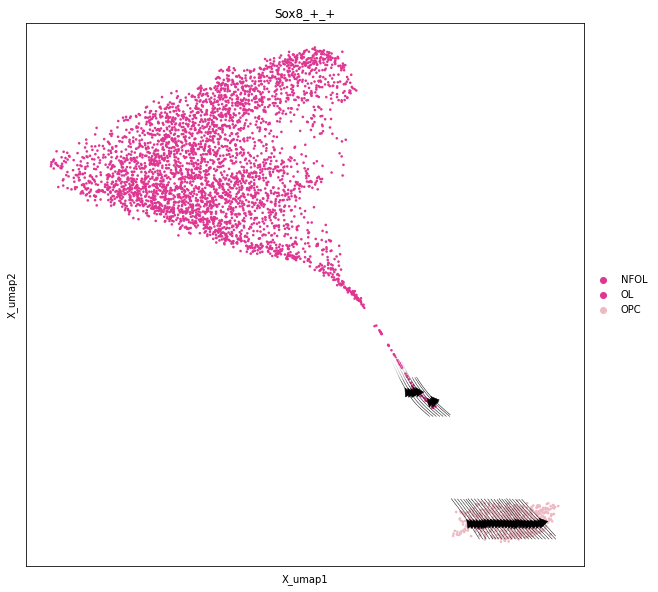

In [40]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Sox8_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0.7, tf_expr_thr=0.7, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Sox8.pdf')

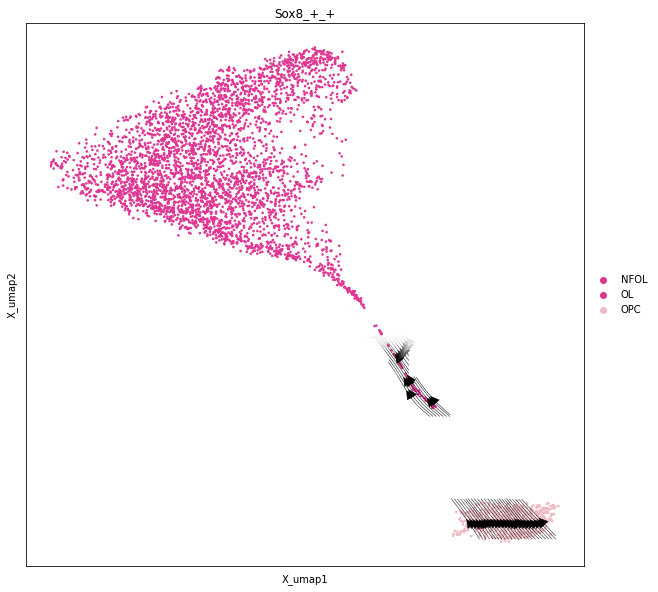

In [62]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Sox8_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0, tf_expr_thr=0.2, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Sox8_nothr.pdf')

### 7. Sox10

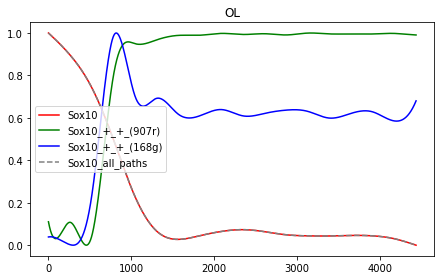

In [41]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'OL', 'Sox10_+_+', window=1, gam_smooth=True, return_data = True, use_ranked_dpt=True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/curve_plots/Sox10.pdf')

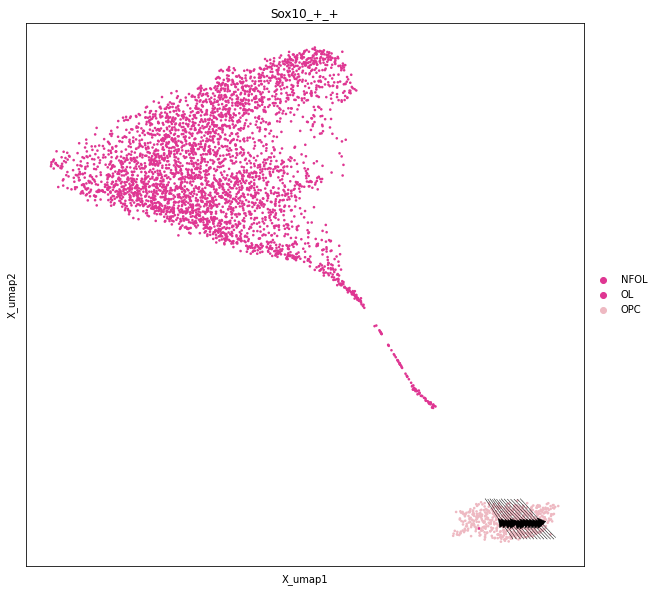

In [42]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Sox10_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0.7, tf_expr_thr=0.7, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Sox10.pdf')

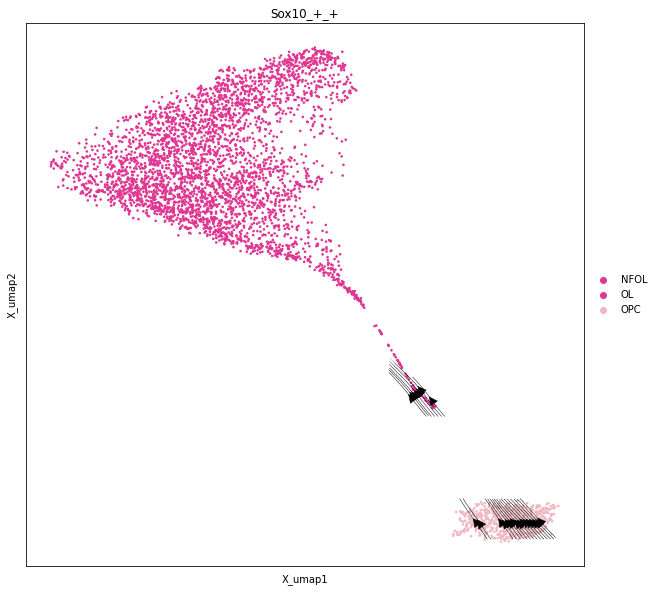

In [63]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Sox10_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0, tf_expr_thr=0.2, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Sox10_nothr.pdf')

### 8. Tcf7l2

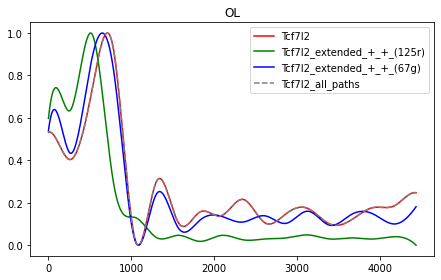

In [44]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'OL', 'Tcf7l2_extended_+_+', window=1, gam_smooth=True, return_data = True, use_ranked_dpt=True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/curve_plots/Tcf7l2.pdf')

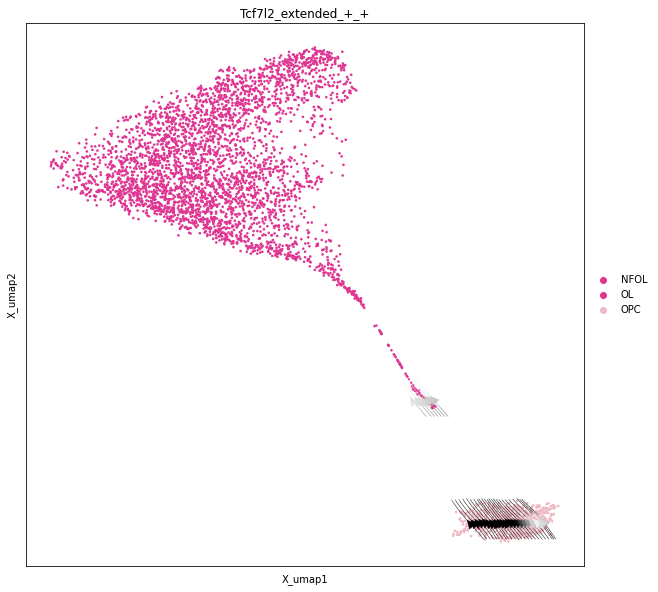

In [45]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Tcf7l2_extended_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0.7, tf_expr_thr=0.7, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Tcf7l2.pdf')

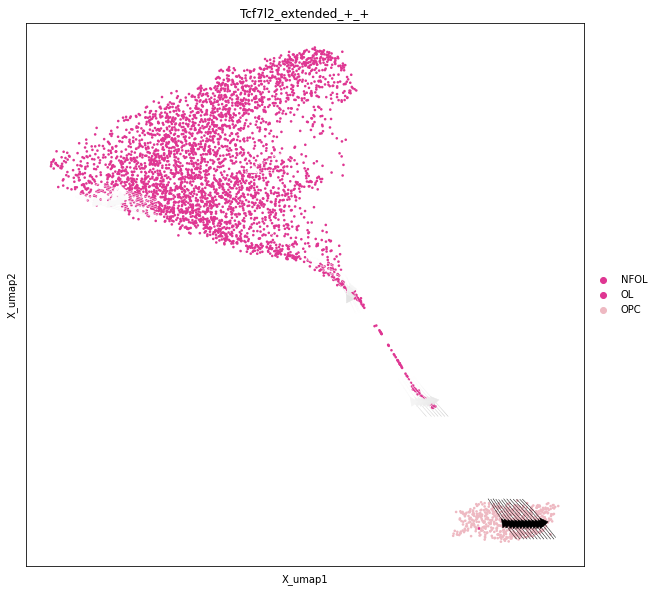

In [64]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Tcf7l2_extended_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0, tf_expr_thr=0.2, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Tcf7l2_nothr.pdf')

### 8. Tcf7l1

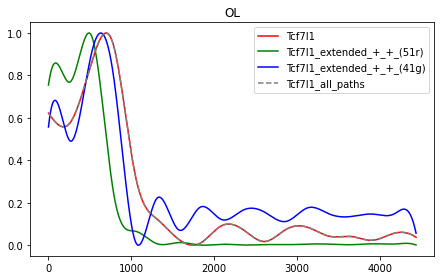

In [47]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'OL', 'Tcf7l1_+_+', window=1, gam_smooth=True, return_data = True, use_ranked_dpt=True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/curve_plots/Tcf7l1.pdf')

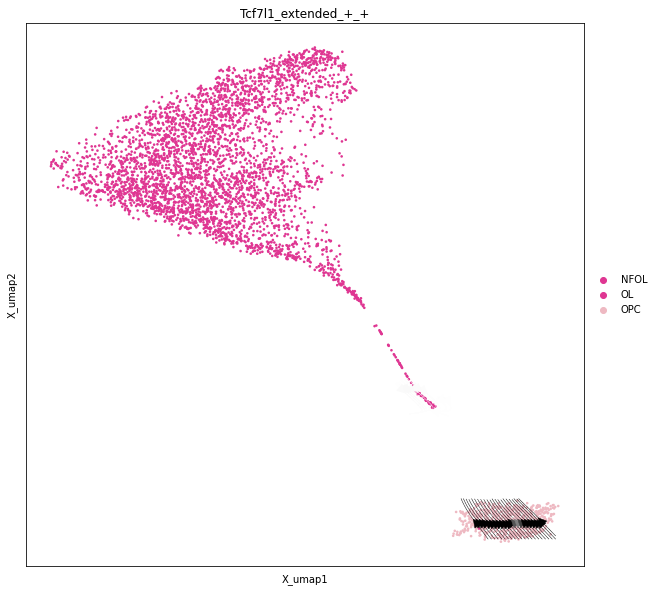

In [48]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Tcf7l1_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0.7, tf_expr_thr=0.7, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Tcf7l1.pdf')

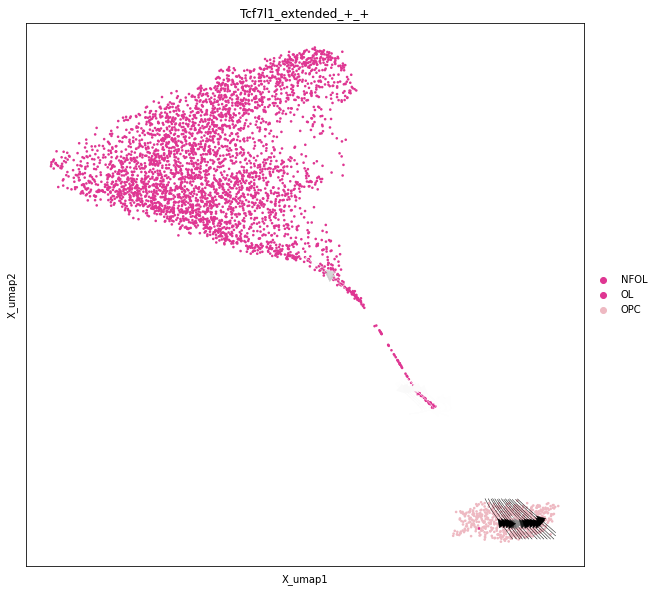

In [67]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Tcf7l1_extended_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0, tf_expr_thr=0.2, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Tcf7l1_nothr.pdf')

### 10. Tcf12

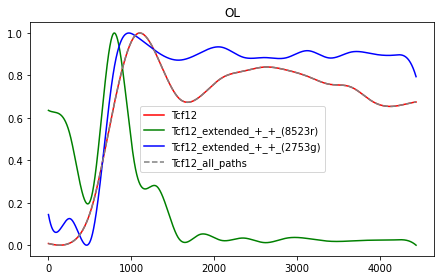

In [50]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'OL', 'Tcf12_extended_+_+', window=1, gam_smooth=True, return_data = True, use_ranked_dpt=True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/curve_plots/Tcf12.pdf')

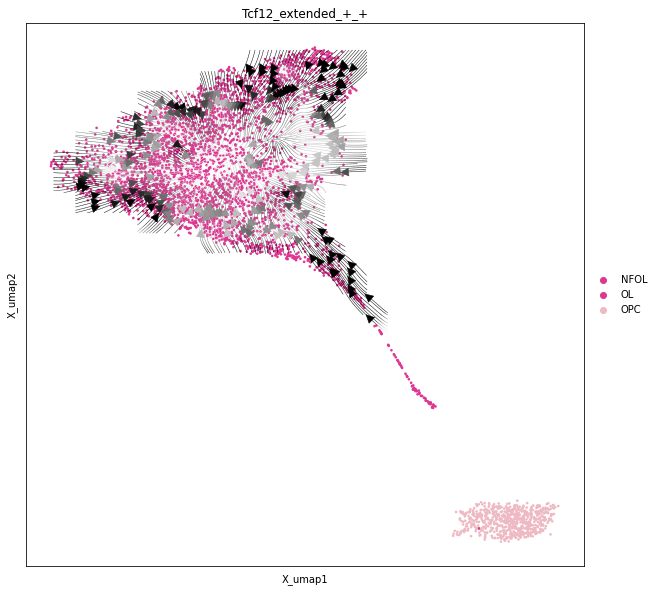

In [52]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Tcf12_extended_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0.7, tf_expr_thr=0.7, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Tcf12.pdf')

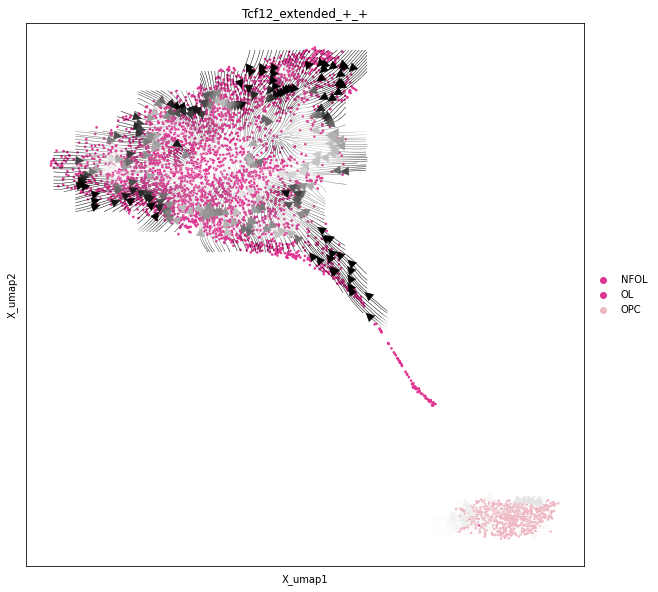

In [68]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Tcf12_extended_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0, tf_expr_thr=0.2, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Tcf12_nothr.pdf')

### 11. Tcf4

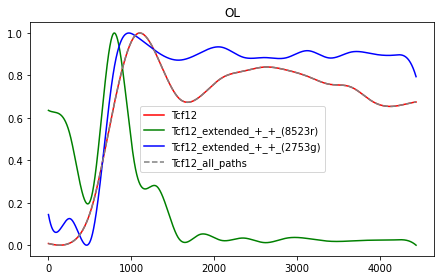

In [50]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'OL', 'Tcf4_+_+', window=1, gam_smooth=True, return_data = True, use_ranked_dpt=True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/curve_plots/Tcf4.pdf')

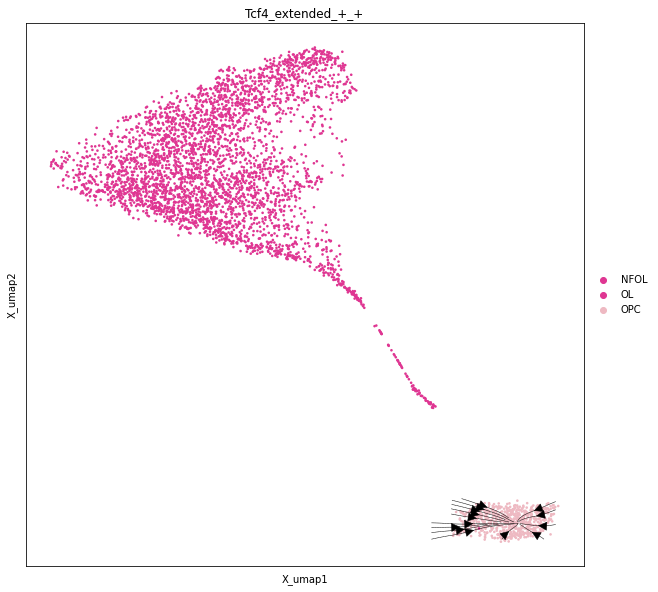

In [53]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Tcf4_extended_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0.7, tf_expr_thr=0.7, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Tcf4.pdf')

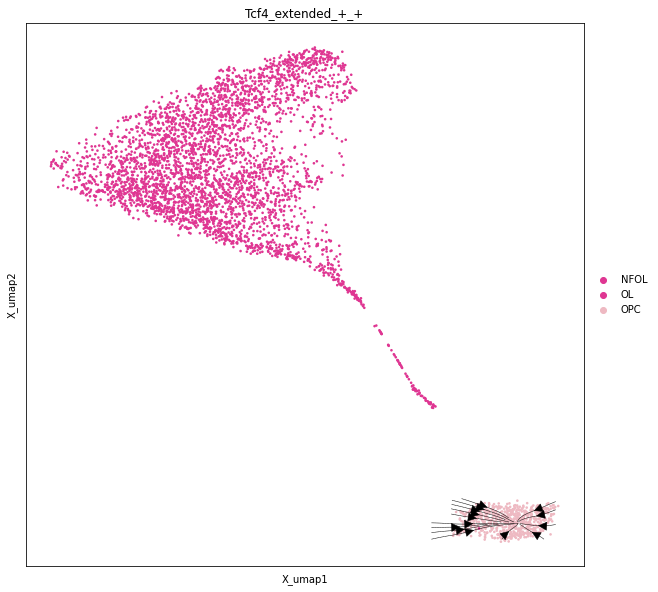

In [69]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Tcf4_extended_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0, tf_expr_thr=0.2, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Tcf4_nothr.pdf')

### 12. Tcf12

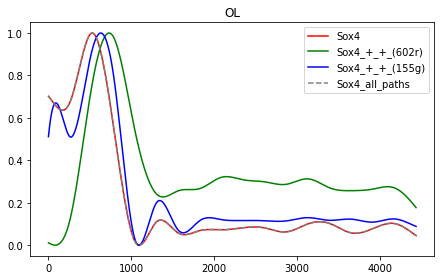

In [35]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'OL', 'Sox2_+_+', window=1, gam_smooth=True, return_data = True, use_ranked_dpt=True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/curve_plots/Sox2.pdf')

In [ ]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Sox2_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0.7, tf_expr_thr=0.7, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Sox2.pdf')

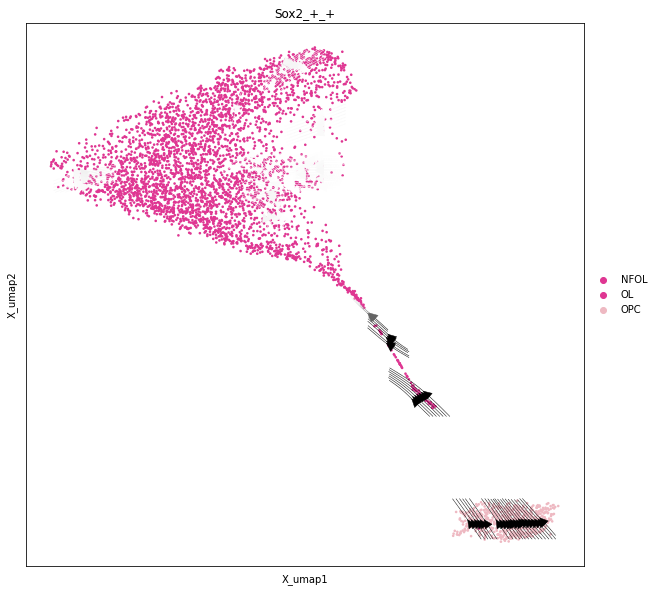

In [70]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Sox2_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0, tf_expr_thr=0.2, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Sox2_nothr.pdf')

### 13. Zeb2

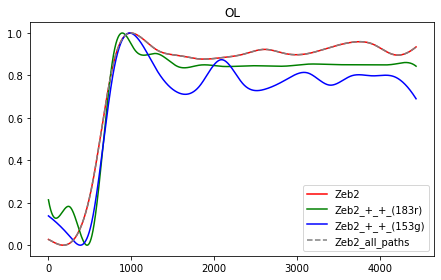

In [71]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'OL', 'Zeb2_+_+', window=1, gam_smooth=True, return_data = True, use_ranked_dpt=True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/curve_plots/Zeb2.pdf')

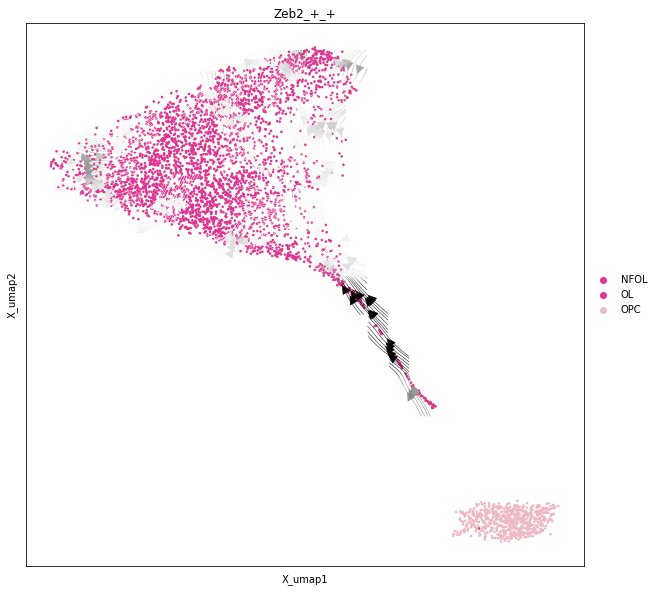

In [74]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Zeb2_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0.7, tf_expr_thr=0.7, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Zeb2.pdf')

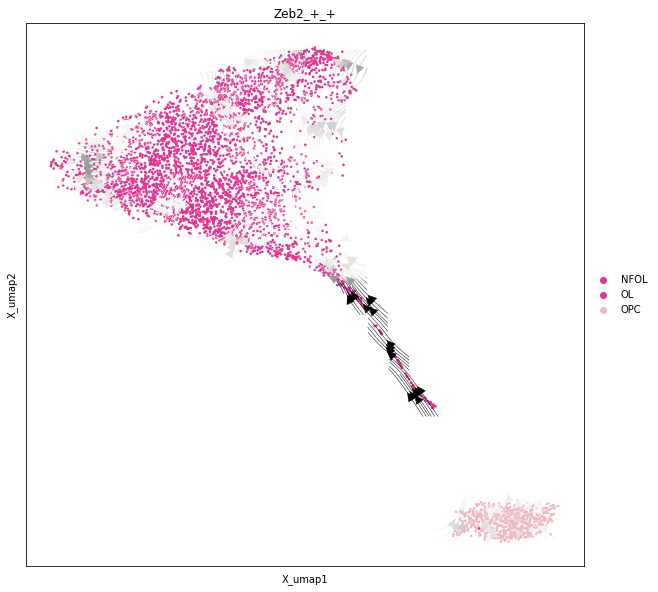

In [75]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Zeb2_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0, tf_expr_thr=0.2, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Zeb2_nothr.pdf')

### 14. Foxn3

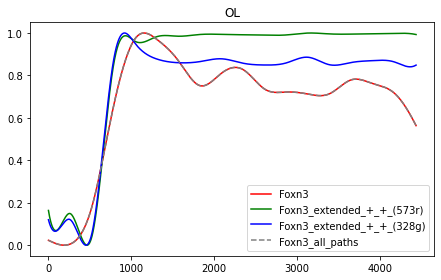

In [76]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'OL', 'Foxn3_extended_+_+', window=1, gam_smooth=True, return_data = True, use_ranked_dpt=True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/curve_plots/Foxn3.pdf')

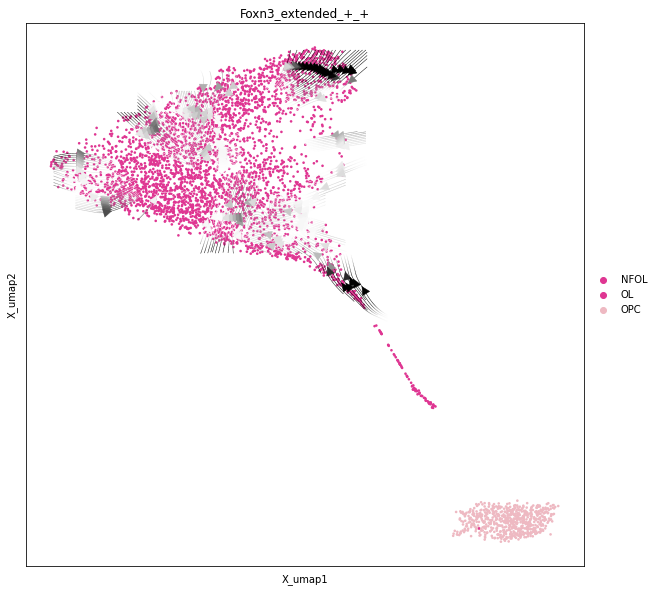

In [77]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Foxn3_extended_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0.7, tf_expr_thr=0.7, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Foxn3.pdf')

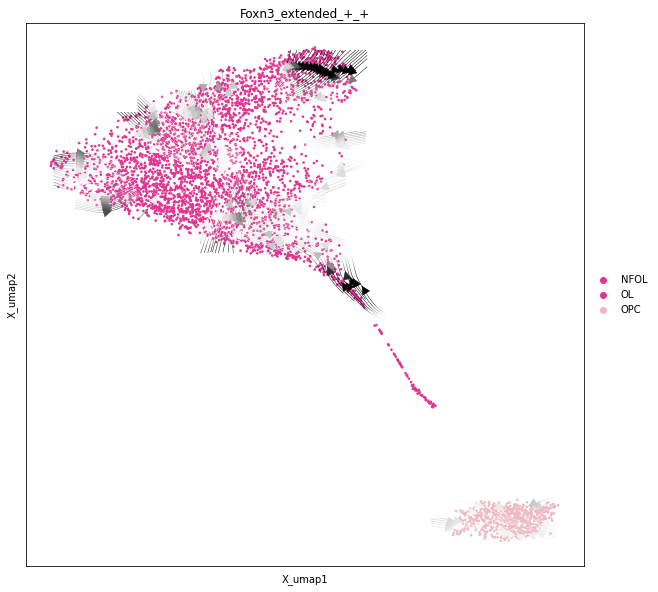

In [78]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Foxn3_extended_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0, tf_expr_thr=0.2, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Foxn3_nothr.pdf')

### 15. Meis1

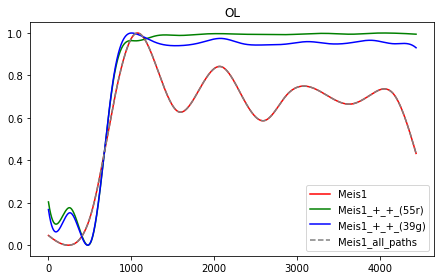

In [79]:
# Plot changes along trajectory
fig, ax = plt.subplots(figsize =(12, 4))
plt.subplot(1, 2, 1)
df_1 = plot_potential(adata, paths_cascade, 'OL', 'Meis1_+_+', window=1, gam_smooth=True, return_data = True, use_ranked_dpt=True)
plt.tight_layout()
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/curve_plots/Meis1.pdf')

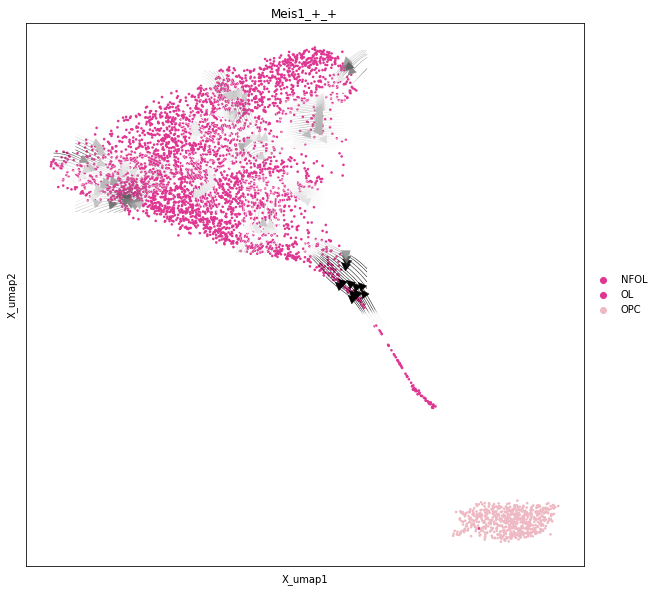

In [84]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Meis1_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0.7, tf_expr_thr=0.7, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Meis1.pdf')

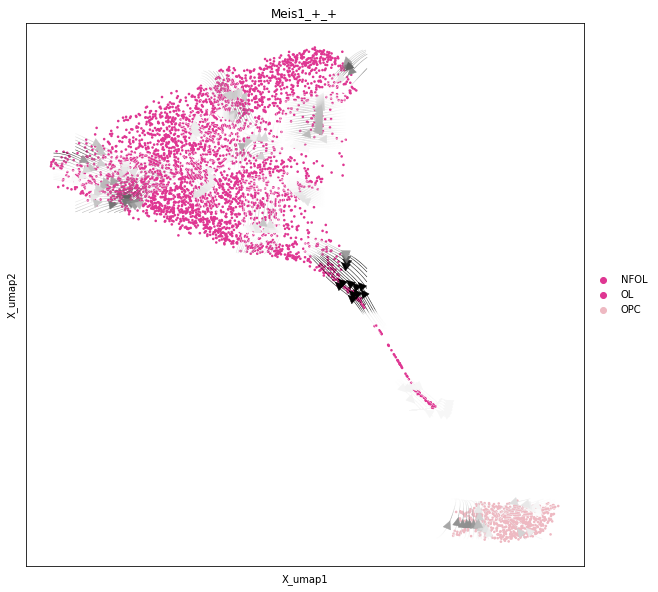

In [83]:
# Plot arrows
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (14,10)}):
    plot_map(adata, paths_cascade, 'Meis1_+_+', color_var='Diff_state', window=1, n_grid_cols = 25, n_grid_rows = 25, n_neighbors = 10,
             tf_traj_thr=0, tf_expr_thr=0.2, scale=50, figsize=(10,10), gam_smooth=True, use_ranked_dpt=True, return_data = True, penalization = 0.03,offset_frac = 0.005, palette={
            "OPC": "#eeb9c2",
            "NFOL": "#df3692",
            "OL": "#df3692",
        }, save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/diff_plot/arrow_plots/Meis1_nothr.pdf')

### C. Calculate the most relevant forces for a cell

#### I. Calculate forces per cell

In [13]:
# To read
import scanpy as sc
adata = sc.read_h5ad('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/differenrentiation_tutorial_4.h5ad')

In [14]:
# Set paths
paths = [('OL', ['OPC', 'NFOL', 'OL'])]

In [15]:
# Calculate path matrices
## Select path features
import os
selected_features = {}
selected_features['TF'] = list(set([x.split('_')[0] for x in adata.var.index.tolist() if 'g)' in x]))
selected_features['Region'] = [x for x in adata.var.index.tolist() if 'r)' in x]
selected_features['Gene'] = [x for x in adata.var.index.tolist() if 'g)' in x]
## Calculate
os.chdir('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/scenicplus/src/scenicplus')
from differentiation_potential import *
paths_cascade = {'TF':{}, 'Region':{}, 'Gene':{}}
for x in paths_cascade.keys():
    for ipath, (descr, path) in enumerate(paths):
        mat= get_path_matrix(
                adata, dpt_var = 'distance',
                path_var = 'clusters',
                path = path, features = selected_features[x],
                split_groups = True)
        paths_cascade[x][descr] = mat

In [6]:
# We will do only for the positives as example
ke = list(paths_cascade[list(paths_cascade.keys())[0]].keys())
selected_eGRNs = [x.split('_(')[0] for x in paths_cascade['Gene'][ke[0]].columns if '+_+' in x]
len(selected_eGRNs)

400

In [ ]:
# Run in a tmux session, check that the server is not too busy
import time
start_time = time.time()
df = cell_forces(adata, paths_cascade, plot_type='tf_to_gene', window=1, gam_smooth=True, tf_traj_thr=0.7, tf_expr_thr=0.2,
               selected_eGRNs=selected_eGRNs, n_cpu=20, _temp_dir='/scratch/leuven/313/vsc31305/ray_spill')
print(time.time() - start_time)
#~10 min
# Save
import dill
with open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/differenrentiation_tutorial_cell_forces.h5ad', 'wb') as f:
    dill.dump(df, f)

In [10]:
# Save
import dill
with open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/differenrentiation_tutorial_cell_forces.h5ad', 'wb') as f:
    dill.dump(df, f)

#### II. Plot RSS

In [363]:
# Load
import dill
infile = open('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/differenrentiation_tutorial_cell_forces.h5ad', 'rb')
df = dill.load(infile)
infile.close()

In [364]:
df=df.div(df.sum(axis=1), axis=0)

In [365]:
df = df.loc[:, df.sum() >0]

In [366]:
df=df.fillna(0)

In [3]:
# To read
import scanpy as sc
adata = sc.read_h5ad('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/differenrentiation_tutorial_4.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 4435 × 16885
    obs: 'GEX_orig.ident', 'GEX_Leiden_res1', 'GEX_consensus_cell_type', 'GEX_conserved_cell_type', 'GEX_location', 'GEX_sample_id', 'GEX_barcode', 'ACC_cisTopic_nr_acc', 'ACC_cisTopic_nr_frag', 'ACC_FRIP', 'ACC_Unique_nr_frag_in_regions', 'ACC_Log_total_nr_frag', 'ACC_Dupl_rate', 'ACC_Dupl_nr_frag', 'ACC_cisTopic_log_nr_acc', 'ACC_Total_nr_frag', 'ACC_Total_nr_frag_in_regions', 'ACC_Unique_nr_frag', 'ACC_Log_unique_nr_frag', 'ACC_TSS_enrichment', 'leiden', 'Diff_state', 'dpt_pseudotime', 'distance', 'clusters'
    uns: 'Diff_state_colors', 'Diff_state_sizes', 'GEX_consensus_cell_type_colors', 'GEX_consensus_cell_type_sizes', 'GEX_sample_id_colors', 'clusters_colors', 'diffmap_evals', 'draw_graph', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'paga', 'pca', 'tsne', 'umap'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_pca_harmony', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

In [368]:
# We'll filter lowly expressed TFs in this branch
import numpy as np
adata.var['Score'] = np.count_nonzero(adata.X > 1.5, axis=0)

In [369]:
# Set paths
paths = [('OL', ['OPC', 'NFOL', 'OL'])]

In [370]:
# Calculate path matrices
## Select path features
import os
selected_features = {}
selected_features['TF'] = list(set([x.split('_')[0] for x in adata.var.index.tolist() if 'g)' in x]))
selected_features['Region'] = [x for x in adata.var.index.tolist() if 'r)' in x]
selected_features['Gene'] = [x for x in adata.var.index.tolist() if 'g)' in x]
## Calculate
os.chdir('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/scenicplus/src/scenicplus')
from differentiation_potential import *
paths_cascade = {'TF':{}, 'Region':{}, 'Gene':{}}
for x in paths_cascade.keys():
    for ipath, (descr, path) in enumerate(paths):
        mat= get_path_matrix(
                adata, dpt_var = 'distance',
                path_var = 'clusters',
                path = path, features = selected_features[x],
                split_groups = True)
        paths_cascade[x][descr] = mat

In [371]:
import pandas as pd
subset = pd.read_csv('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/HQ_regulons.tsv').iloc[:,0].tolist()
subset = [x.split('_')[0] for x in subset]
s = [x.split('_(')[0] for x in selected_features['Gene'] if '+_+' in x and x.split('_')[0] in subset and x.split('_(')[0] in df.columns and adata.var['Score'].loc[x.split('_')[0]] > 30]
#s = [x.split('_(')[0] for x in selected_features['Gene'] if '+_+' in x and x.split('_')[0] in subset and x.split('_(')[0] in df.columns]

In [372]:
[x for x in s if 'Prrx' in x]

['Prrx1_+_+', 'Prrx1_extended_+_+']

In [412]:
rss_values = forces_rss(adata, df, 'Diff_state')
#rss_values = rss_values[s]

In [413]:
direct_eRegulons = [x for x in rss_values.columns if not 'extended' in x]
extended_eRegulons =  [x for x in rss_values.columns  if 'extended' in x and not x.replace('_extended', '') in direct_eRegulons]
selected_eRegulons = direct_eRegulons + extended_eRegulons

In [414]:
[x for x in selected_eRegulons if 'Prrx' in x]

['Prrx1_+_+']

In [415]:
selected_eRegulons=['Prrx1(+)', 'Meis1(+)', 'Zeb2(+)', 'Sox10(+)', 'Sox8(+)', 'Olig2(+)', 'Sox4(+)','Sox6(+)','Sox5(+)', 'Tcf4(+)', 'Bcl6_extended(+)','Tcf7l2_extended(+)', 'Tcf12_extended(+)']

In [416]:
import re
rss_values.columns = [re.sub('_\+_\+', '(+)', file) for file in rss_values.columns]

In [417]:
rss_values = rss_values[selected_eRegulons]

In [418]:
rss_values.columns = [re.sub('_extended', '', file) for file in rss_values.columns]

In [419]:
rss_values.columns

Index(['Prrx1(+)', 'Meis1(+)', 'Zeb2(+)', 'Sox10(+)', 'Sox8(+)', 'Olig2(+)',
       'Sox4(+)', 'Sox6(+)', 'Sox5(+)', 'Tcf4(+)', 'Bcl6(+)', 'Tcf7l2(+)',
       'Tcf12(+)'],
      dtype='object')

In [420]:
rss_values = rss_values.loc[['OPC', 'NFOL', 'OL'],:]

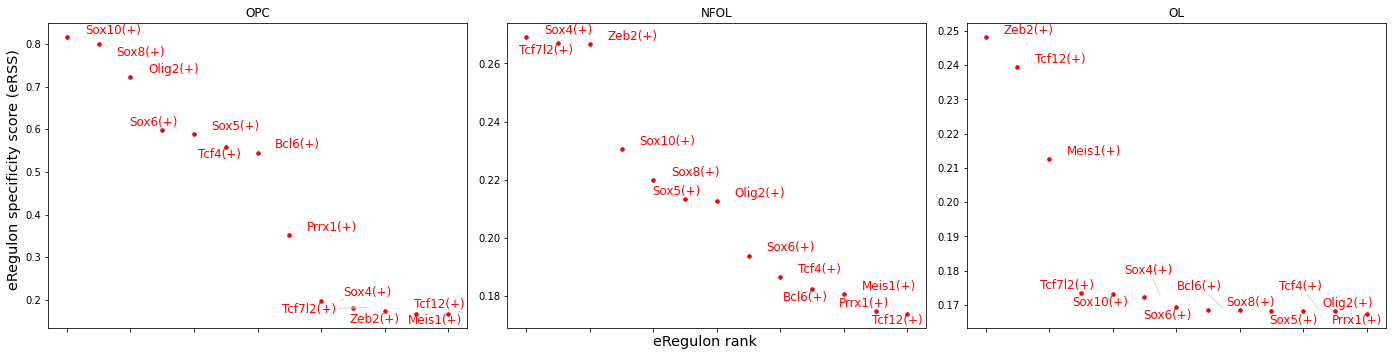

In [422]:
plot_forces_rss(rss_values, top_n=20, num_columns=3, selected_groups=['OPC', 'NFOL', 'OL'], save='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/prior.pdf')

In [144]:
[x for x in adata.var.index if 'Prrx' in x]

['Prrx1_+_+_(98g)',
 'Prrx1_extended_+_+_(172g)',
 'Prrx1_-_+_(23g)',
 'Prrx1_extended_-_+_(26g)',
 'Prrx1_-_+_(76r)',
 'Prrx1_extended_+_+_(389r)',
 'Prrx1_+_+_(177r)',
 'Prrx1_extended_-_+_(126r)',
 'Prrx1']

In [150]:
gene_names = ['Olig2', 'Bcl6', 'Prrx1', 'Tcf7l2', 'Sox8', 'Zeb2', 'Meis1', 'Tcf12']
[y for y in adata.var.index for x in gene_names if x+'_' in y and 'g' in y and '+_+' in y]

['Prrx1_+_+_(98g)',
 'Meis1_+_+_(39g)',
 'Zeb2_+_+_(153g)',
 'Olig2_extended_+_+_(107g)',
 'Bcl6_extended_+_+_(149g)',
 'Tcf12_extended_+_+_(2753g)',
 'Sox8_+_+_(322g)',
 'Prrx1_extended_+_+_(172g)',
 'Olig2_+_+_(93g)',
 'Sox8_extended_+_+_(397g)',
 'Tcf7l2_extended_+_+_(67g)',
 'Meis1_extended_+_+_(114g)',
 'Olig2_+_+_(183r)',
 'Olig2_extended_+_+_(245r)']

/opt/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/paga.py:1226: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/opt/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/paga.py:1273: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)
/local_scratch/tmp-vsc31305/ipykernel_31398/2692825188.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/Differentiation_heatmap_v2_magma.pdf')
/opt/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.ca

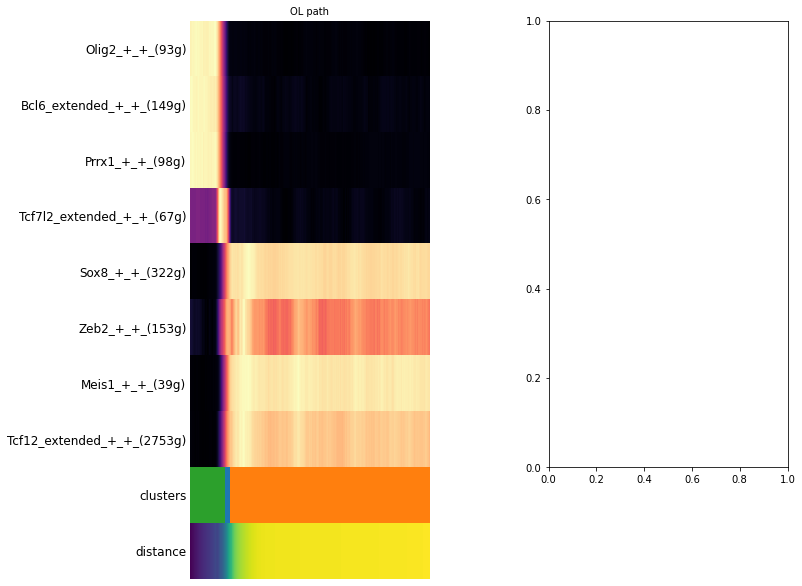

In [402]:
# For plotting
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as pl
gene_names = ['Olig2_+_+_(93g)', 'Bcl6_extended_+_+_(149g)', 'Prrx1_+_+_(98g)', 'Tcf7l2_extended_+_+_(67g)', 'Sox8_+_+_(322g)', 'Zeb2_+_+_(153g)', 'Meis1_+_+_(39g)', 'Tcf12_extended_+_+_(2753g)',]
_, axs = pl.subplots(ncols=2, figsize=(10, 10), gridspec_kw={'wspace': 0.5})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
path_x={}
for ipath, (descr, path) in enumerate(paths):
    _, path_x[descr] = sc.pl.paga_path(
        adata, path, gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=200,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='magma',
        groups_key='clusters',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        normalize_to_zero_one=True,
        return_data=True,
        show=False)
    
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/Differentiation_heatmap_v2_magma.pdf')

/opt/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/paga.py:1226: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/opt/venv/lib/python3.8/site-packages/scanpy/plotting/_tools/paga.py:1273: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)
/local_scratch/tmp-vsc31305/ipykernel_31398/2538800320.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/Differentiation_heatmap_genes_v2_viridis.pdf')
/opt/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


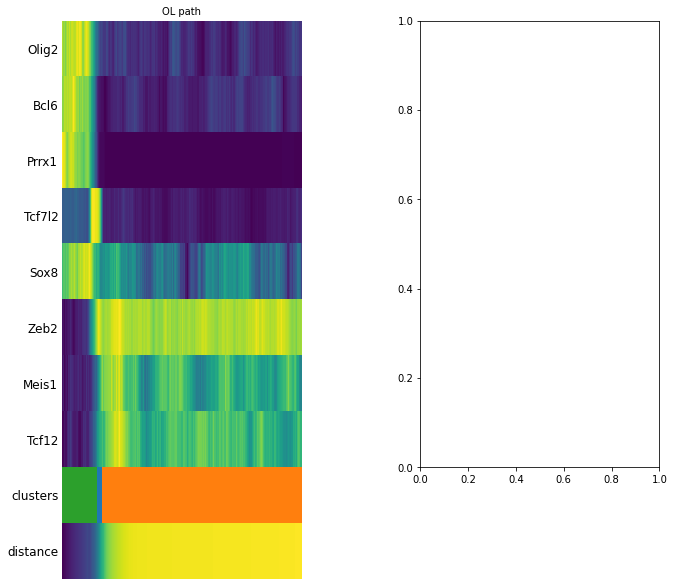

In [172]:
# For plotting
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as pl
#gene_names = ['Olig2_+_+_(93g)', 'Bcl6_extended_+_+_(149g)', 'Tcf4_+_+_(2191g)', 'Tcf7l2_extended_+_+_(67g)', 'Sox10_+_+_(168g)', 'Onecut2_extended_+_+_(100g)', 'Hbp1_extended_+_+_(149g)', 'Tcf12_extended_+_+_(2753g)',]
gene_names = ['Olig2', 'Bcl6', 'Prrx1','Tcf7l2', 'Sox8', 'Zeb2', 'Meis1', 'Tcf12']
_, axs = pl.subplots(ncols=2, figsize=(10, 10), gridspec_kw={'wspace': 0.5})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
path_x={}
for ipath, (descr, path) in enumerate(paths):
    _, path_x[descr] = sc.pl.paga_path(
        adata, path, gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=200,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='viridis',
        groups_key='clusters',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        normalize_to_zero_one=True,
        return_data=True,
        show=False)
    
plt.savefig('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/scenicplus_v10_v2/grnboost_autoreg/Differentiation_heatmap_genes_v2_viridis.pdf')

